In [1]:
import numpy as np
import pandas as pd
import pypianoroll as pr
import matplotlib.pyplot as plt
import importlib
import json
import xml.etree.ElementTree as ET
import os
import sys
import pickle
from time import time

import torch
from torch import nn
import numpy as np
from torch.nn import functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable

#### 读取数据

In [2]:
sys.path.append('..')
import dataloader
importlib.reload(dataloader)
import model
#importlib.reload(model)
from dataloader import DataLoader
importlib.reload(DataLoader)
from model.DeepModel import * 
#importlib.reload(model.DeepModel)
DL = DataLoader.DataLoader(device='cpu')
# DL.process_raw_data()

reading global_chord_num_dic
reading global_num_chord_dic
reading global_num_chord_one_hot_dic
reading double_compressed_data


#### 统计大小调所有和弦数目，出现的三，七和弦数目以及全部使用三，七和弦的样本数

In [3]:
total = 0  # 出现的和弦总数
triad_num = 0  # 三和弦总数
triad_num_dic = {'minor':{i:0 for i in DL.global_chord_num_dic['minor'].keys()},
                 'major':{i:0 for i in DL.global_chord_num_dic['major'].keys()}}
triad_sample_num = 0 # 全部使用三和弦的样本数
triad_samples = {'major': [], 'minor': []}
for sample in DL.double_compressed_data:
    if sample['key'] in ['A','B','C','D','E','F','G']:
        m = 'major'
    else:
        m = 'minor'
    sample_copy = sample.copy()
    melody = sample['melody']
    chord = sample['chord']
    t = True
    for i in range(len(melody)):
        total += 1
        try:
            DL.global_chord_num_dic[m][chord[i]]
            triad_num_dic[m][chord[i]] += 1
            triad_num += 1
        except:
            if len(chord[i]) < 3:
                for c in DL.global_chord_num_dic[m].keys():
                    if melody[i] not in c:
                        continue
                    for k in chord[i]:
                        if k not in c:
                            break
                    else:
                        sample_copy['chord'][i] = c
                        triad_num_dic[m][c] += 1
                        triad_num += 1
                        break
                else:
                    t = False
            else:
                t = False
                pass
    if t:
        triad_samples[m].append(sample_copy)
        triad_sample_num += 1

print(total)
print(triad_num)
print(triad_sample_num)

306469
142234
3329


## 模型训练

In [4]:
import AutoChord
importlib.reload(AutoChord)
from AutoChord import AutoChord
importlib.reload(AutoChord)
AC = AutoChord.AutoChord()

reading global_chord_num_dic
reading global_num_chord_dic
reading global_num_chord_one_hot_dic
reading double_compressed_data


#### 小调不加权

In [15]:
DL.get_train_data(min_length=1, write_cache=False, 
                  valid_compressed_data=triad_samples['minor'],
                  tonic='minor')

total 9928 valid train_data


In [23]:
params = arams = {'chord_num': 48, 'device': 'cuda'}
AC.get_model(model_name='lstm', params=params)
train_loss, test_loss = AC.fit(DL.train_data[:7000], DL.train_data[7000:], epochs=0)

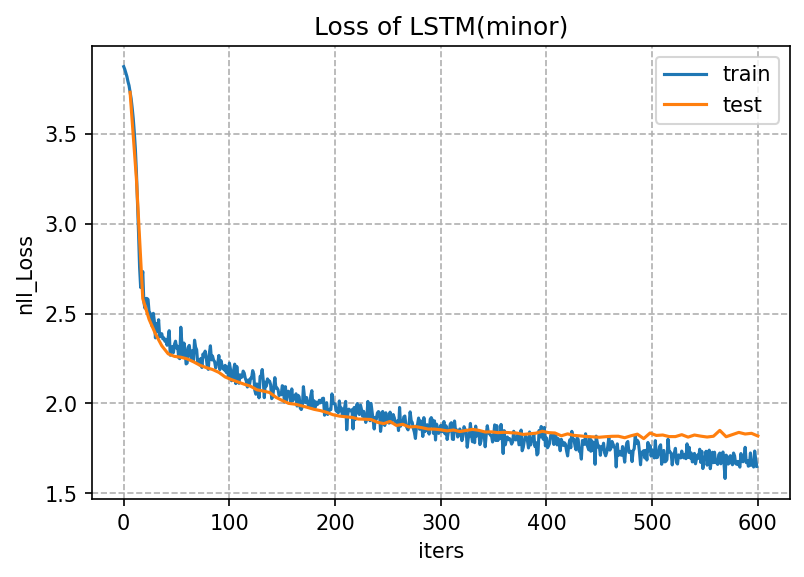

In [31]:
plt.figure(dpi=150)
plt.plot(train_loss,label='train')
plt.plot([i*6 for i in range(1,101)], test_loss[:], label='test')
plt.xlabel('iters')
plt.grid(linestyle='--')
plt.legend()
plt.ylabel('nll_Loss')
plt.title('Loss of LSTM(minor)')
plt.show()

In [34]:
torch.save(AC.model.model, '../trained_models/minor_lstm')

#### 大调不加权

In [35]:
DL.get_train_data(min_length=1, write_cache=False,
                  valid_compressed_data=triad_samples['major'], tonic='major')

10000 valid train_data
20000 valid train_data
30000 valid train_data
total 32003 valid train_data


In [24]:
params = arams = {'chord_num': 48, 'device': 'cuda'}
AC.get_model(model_name='lstm', params=params)
train_loss, test_loss = AC.fit(DL.train_data[:22000], DL.train_data[22000:], epochs=0)

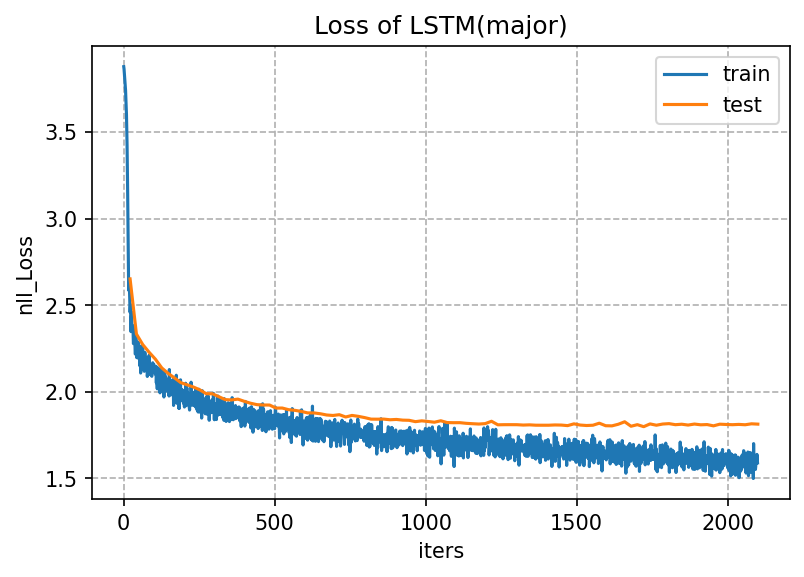

In [37]:
plt.figure(dpi=150)
plt.plot(train_loss,label='train')
plt.plot([i*21 for i in range(1,101)], test_loss[:], label='test')
plt.xlabel('iters')
plt.grid(linestyle='--')
plt.legend()
plt.ylabel('nll_Loss')
plt.title('Loss of LSTM(major)')
plt.show()

In [38]:
torch.save(AC.model.model, '../trained_models/major_lstm')

In [ ]:
#### 小调加权

#### 马尔科夫链训练以及评估nll_loss

#### 小调

In [16]:
DL.get_train_data(min_length=1, write_cache=False, 
                  valid_compressed_data=triad_samples['minor'],
                  tonic='minor')

total 9928 valid train_data


In [17]:
AC.get_model(model_name='markov')
AC.fit(DL.train_data[:7000])

In [21]:
loss = 0
for sample in DL.train_data[:7000]:
    i = np.argsort(sample[0][-1].numpy())[-1]
    tar = sample[3].numpy()
    loss -= np.log(AC.model.transition_matrix[i][tar])
loss /= len(DL.train_data[:7000])
print('IS: {:.4f}'.format(loss))

for sample in DL.train_data[7000:]:
    i = np.argsort(sample[0][-1].numpy())[-1]
    tar = sample[3].numpy()
    if AC.model.transition_matrix[i][tar] == 0:
        # print(i,tar)
        continue
    loss -= np.log(AC.model.transition_matrix[i][tar])
loss /= len(DL.train_data[7000:])
print('OS: {:.4f}'.format(loss))

IS: 2.0865
OS: 1.9961


#### 大调

In [22]:
DL.get_train_data(min_length=1, write_cache=False, 
                  valid_compressed_data=triad_samples['major'],
                  tonic='major')
AC.get_model(model_name='markov')
AC.fit(DL.train_data[:22000])

for sample in DL.train_data[:22000]:
    i = np.argsort(sample[0][-1].numpy())[-1]
    tar = sample[3].numpy()
    loss -= np.log(AC.model.transition_matrix[i][tar])
loss /= len(DL.train_data[:22000])
print('IS: {:.4f}'.format(loss))

for sample in DL.train_data[22000:]:
    i = np.argsort(sample[0][-1].numpy())[-1]
    tar = sample[3].numpy()
    if AC.model.transition_matrix[i][tar] == 0:
        # print(i,tar)
        continue
    loss -= np.log(AC.model.transition_matrix[i][tar])
loss /= len(DL.train_data[22000:])
print('OS: {:.4f}'.format(loss))

10000 valid train_data
20000 valid train_data
30000 valid train_data
total 32003 valid train_data
IS: 2.0579
OS: 2.0702


#### NN小调不加权

In [6]:
DL.get_train_data(min_length=1, write_cache=False, 
                  valid_compressed_data=triad_samples['minor'],
                  tonic='minor')

params = arams = {'chord_num': 48, 'device': 'cuda'}
AC.get_model(model_name='nn', params=params)
train_loss, test_loss = AC.fit(DL.train_data[:7000], DL.train_data[7000:], epochs=100)

total 9928 valid train_data
loss: 3.8757 time used: 0.4615s
loss: 3.8572 time used: 0.4595s
loss: 3.8455 time used: 0.4575s
loss: 3.8263 time used: 0.4596s
loss: 3.8156 time used: 0.4565s
loss: 3.8003 time used: 0.4590s
epoch 0 testing
test loss: 3.7843 time used: 0.8583s
loss: 3.7816 time used: 0.4539s
loss: 3.7655 time used: 0.4555s
loss: 3.7459 time used: 0.4616s
loss: 3.7295 time used: 0.4570s
loss: 3.7069 time used: 0.4610s
loss: 3.6812 time used: 0.4572s
epoch 1 testing
test loss: 3.6542 time used: 0.8644s
loss: 3.6535 time used: 0.4656s
loss: 3.6283 time used: 0.4590s
loss: 3.6017 time used: 0.4604s
loss: 3.5656 time used: 0.4566s
loss: 3.5255 time used: 0.4604s
loss: 3.4757 time used: 0.4570s
epoch 2 testing
test loss: 3.4398 time used: 0.8615s
loss: 3.4450 time used: 0.4571s
loss: 3.3990 time used: 0.4620s
loss: 3.3543 time used: 0.4620s
loss: 3.2959 time used: 0.4660s
loss: 3.2314 time used: 0.4579s
loss: 3.1744 time used: 0.4604s
epoch 3 testing
test loss: 3.1096 time used: 

loss: 2.0267 time used: 0.4614s
loss: 2.0418 time used: 0.4548s
loss: 2.0844 time used: 0.4606s
loss: 2.1412 time used: 0.4560s
epoch 33 testing
test loss: 2.0687 time used: 0.8599s
loss: 2.0600 time used: 0.4590s
loss: 2.0830 time used: 0.4549s
loss: 2.0738 time used: 0.4604s
loss: 2.0711 time used: 0.4545s
loss: 2.0013 time used: 0.4544s
loss: 2.1196 time used: 0.4580s
epoch 34 testing
test loss: 2.0688 time used: 0.8533s
loss: 2.0961 time used: 0.4540s
loss: 2.0616 time used: 0.4567s
loss: 2.0891 time used: 0.4554s
loss: 2.1768 time used: 0.4570s
loss: 2.0618 time used: 0.4530s
loss: 1.9718 time used: 0.4564s
epoch 35 testing
test loss: 2.0669 time used: 0.8509s
loss: 2.0646 time used: 0.4571s
loss: 2.0119 time used: 0.4550s
loss: 2.0855 time used: 0.4570s
loss: 2.0866 time used: 0.4554s
loss: 2.0723 time used: 0.4590s
loss: 2.0850 time used: 0.4560s
epoch 36 testing
test loss: 2.0629 time used: 0.8590s
loss: 2.0749 time used: 0.4549s
loss: 2.1247 time used: 0.4542s
loss: 2.0267 tim

loss: 2.0401 time used: 0.4565s
epoch 66 testing
test loss: 2.0340 time used: 0.8499s
loss: 2.0052 time used: 0.4500s
loss: 2.0304 time used: 0.4520s
loss: 2.0306 time used: 0.4550s
loss: 2.0196 time used: 0.4530s
loss: 2.0044 time used: 0.4567s
loss: 2.0357 time used: 0.4510s
epoch 67 testing
test loss: 2.0305 time used: 0.8530s
loss: 2.0149 time used: 0.4574s
loss: 2.0111 time used: 0.4510s
loss: 2.0311 time used: 0.4614s
loss: 2.0438 time used: 0.4535s
loss: 1.9666 time used: 0.4555s
loss: 2.0095 time used: 0.4570s
epoch 68 testing
test loss: 2.0281 time used: 0.8569s
loss: 2.0078 time used: 0.4550s
loss: 2.0888 time used: 0.4575s
loss: 2.0308 time used: 0.4535s
loss: 1.9806 time used: 0.4554s
loss: 1.9591 time used: 0.4596s
loss: 1.9739 time used: 0.4584s
epoch 69 testing
test loss: 2.0309 time used: 0.8544s
loss: 2.0625 time used: 0.4572s
loss: 1.9749 time used: 0.4520s
loss: 1.9987 time used: 0.4566s
loss: 2.0245 time used: 0.4529s
loss: 2.0044 time used: 0.4570s
loss: 2.0039 tim

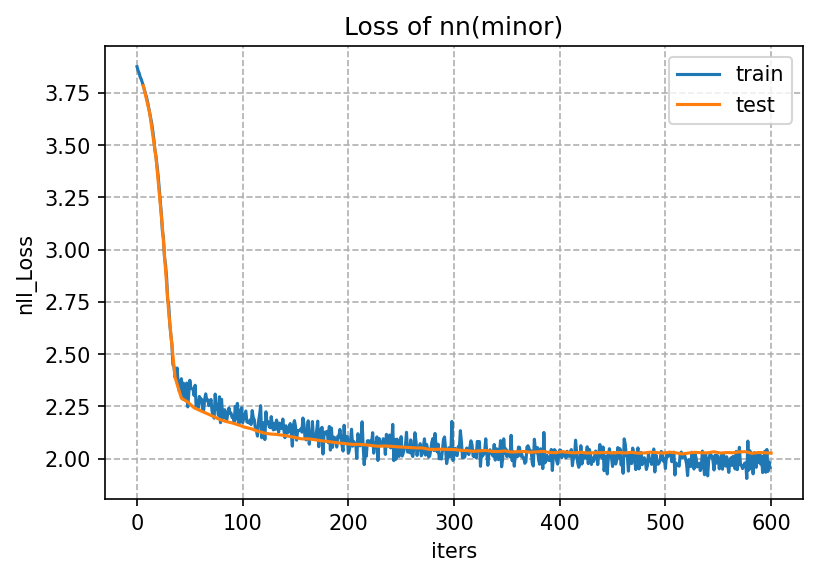

In [7]:
plt.figure(dpi=150)
plt.plot(train_loss,label='train')
plt.plot([i*6 for i in range(1,101)], test_loss[:], label='test')
plt.xlabel('iters')
plt.grid(linestyle='--')
plt.legend()
plt.ylabel('nll_Loss')
plt.title('Loss of nn(minor)')
plt.show()

#### nn大调不加权

In [8]:
DL.get_train_data(min_length=1, write_cache=False, 
                  valid_compressed_data=triad_samples['major'],
                  tonic='major')

params = arams = {'chord_num': 48, 'device': 'cuda'}
AC.get_model(model_name='nn', params=params)
train_loss, test_loss = AC.fit(DL.train_data[:22000], DL.train_data[22000:], epochs=100)


10000 valid train_data
20000 valid train_data
30000 valid train_data
total 32003 valid train_data
loss: 3.8626 time used: 0.4824s
loss: 3.8476 time used: 0.4800s
loss: 3.8365 time used: 0.4751s
loss: 3.8165 time used: 0.4824s
loss: 3.8030 time used: 0.4726s
loss: 3.7887 time used: 0.4902s
loss: 3.7727 time used: 0.4781s
loss: 3.7549 time used: 0.4778s
loss: 3.7374 time used: 0.4658s
loss: 3.7198 time used: 0.4806s
loss: 3.7030 time used: 0.4656s
loss: 3.6822 time used: 0.4666s
loss: 3.6585 time used: 0.4634s
loss: 3.6262 time used: 0.4672s
loss: 3.6080 time used: 0.4742s
loss: 3.5818 time used: 0.4721s
loss: 3.5452 time used: 0.4817s
loss: 3.5065 time used: 0.4701s
loss: 3.4702 time used: 0.4692s
loss: 3.4271 time used: 0.4710s
loss: 3.3948 time used: 0.4866s
epoch 0 testing
test loss: 3.3556 time used: 2.3801s
loss: 3.3316 time used: 0.4772s
loss: 3.2737 time used: 0.4795s
loss: 3.2235 time used: 0.4818s
loss: 3.1696 time used: 0.4755s
loss: 3.1076 time used: 0.4705s
loss: 3.0515 time

loss: 1.9522 time used: 0.4618s
loss: 1.9913 time used: 0.4594s
loss: 1.9181 time used: 0.4625s
loss: 2.0774 time used: 0.4610s
loss: 2.0340 time used: 0.4669s
loss: 2.0573 time used: 0.4631s
loss: 2.0510 time used: 0.4633s
loss: 1.9536 time used: 0.4606s
loss: 2.0500 time used: 0.4659s
loss: 1.9853 time used: 0.4737s
loss: 1.9317 time used: 0.4649s
loss: 1.9461 time used: 0.4675s
loss: 2.0182 time used: 0.4650s
loss: 2.0509 time used: 0.4588s
loss: 2.0118 time used: 0.4640s
loss: 2.0559 time used: 0.4588s
loss: 2.0338 time used: 0.4678s
epoch 11 testing
test loss: 2.0714 time used: 2.3556s
loss: 2.0470 time used: 0.4651s
loss: 1.9865 time used: 0.4692s
loss: 1.9964 time used: 0.4646s
loss: 1.9097 time used: 0.4662s
loss: 1.9517 time used: 0.4615s
loss: 2.0215 time used: 0.4721s
loss: 2.0523 time used: 0.4744s
loss: 1.9462 time used: 0.4674s
loss: 1.9602 time used: 0.4607s
loss: 2.0192 time used: 0.4665s
loss: 2.0488 time used: 0.4625s
loss: 2.0104 time used: 0.4652s
loss: 2.0263 time 

loss: 2.0069 time used: 0.4579s
loss: 2.0243 time used: 0.4759s
loss: 2.0199 time used: 0.4686s
loss: 1.9466 time used: 0.4661s
loss: 1.9635 time used: 0.4625s
loss: 1.9681 time used: 0.4638s
loss: 1.8859 time used: 0.4573s
loss: 2.0186 time used: 0.4595s
loss: 1.9439 time used: 0.4690s
loss: 1.9830 time used: 0.4597s
epoch 22 testing
test loss: 2.0546 time used: 2.3316s
loss: 1.9774 time used: 0.4677s
loss: 1.9217 time used: 0.4627s
loss: 1.9749 time used: 0.4569s
loss: 1.9721 time used: 0.4589s
loss: 1.9337 time used: 0.4658s
loss: 2.0152 time used: 0.4707s
loss: 1.9713 time used: 0.4691s
loss: 2.0333 time used: 0.4761s
loss: 2.0121 time used: 0.4609s
loss: 1.9114 time used: 0.4607s
loss: 2.0104 time used: 0.4673s
loss: 1.9220 time used: 0.4754s
loss: 2.0175 time used: 0.4744s
loss: 2.0329 time used: 0.4707s
loss: 1.9639 time used: 0.4756s
loss: 1.9773 time used: 0.4632s
loss: 1.9716 time used: 0.4705s
loss: 1.9244 time used: 0.4626s
loss: 1.9902 time used: 0.4641s
loss: 1.9448 time 

loss: 1.9698 time used: 0.4615s
loss: 1.9428 time used: 0.4609s
loss: 1.9582 time used: 0.4565s
epoch 33 testing
test loss: 2.0424 time used: 2.3169s
loss: 1.9855 time used: 0.4822s
loss: 1.9328 time used: 0.4552s
loss: 1.9875 time used: 0.4618s
loss: 1.9643 time used: 0.4589s
loss: 1.9561 time used: 0.4650s
loss: 1.9726 time used: 0.4616s
loss: 1.9763 time used: 0.4626s
loss: 1.9395 time used: 0.4604s
loss: 1.9563 time used: 0.4706s
loss: 1.9502 time used: 0.4619s
loss: 1.9652 time used: 0.4667s
loss: 1.9407 time used: 0.4628s
loss: 1.9683 time used: 0.4647s
loss: 1.8953 time used: 0.4648s
loss: 1.9560 time used: 0.4578s
loss: 1.9063 time used: 0.4649s
loss: 1.9156 time used: 0.4582s
loss: 1.9722 time used: 0.4664s
loss: 1.9804 time used: 0.4610s
loss: 2.0007 time used: 0.4683s
loss: 1.9192 time used: 0.4610s
epoch 34 testing
test loss: 2.0399 time used: 2.3466s
loss: 2.0136 time used: 0.4554s
loss: 1.9413 time used: 0.4634s
loss: 1.9731 time used: 0.4584s
loss: 2.0215 time used: 0.45

loss: 1.8813 time used: 0.4584s
loss: 1.9979 time used: 0.4574s
loss: 1.9188 time used: 0.4564s
loss: 1.9311 time used: 0.4614s
loss: 1.9779 time used: 0.4544s
loss: 1.9266 time used: 0.4614s
loss: 1.9036 time used: 0.4574s
loss: 1.9417 time used: 0.4574s
loss: 1.8954 time used: 0.4594s
loss: 1.8993 time used: 0.4574s
loss: 2.0108 time used: 0.4624s
loss: 1.9768 time used: 0.4554s
loss: 1.9792 time used: 0.4634s
loss: 1.9516 time used: 0.4564s
loss: 1.9277 time used: 0.4614s
loss: 1.9448 time used: 0.4554s
loss: 1.9669 time used: 0.4614s
loss: 1.9137 time used: 0.4574s
loss: 1.9338 time used: 0.4604s
epoch 45 testing
test loss: 2.0333 time used: 2.3064s
loss: 1.8897 time used: 0.4534s
loss: 1.8769 time used: 0.4604s
loss: 1.9424 time used: 0.4554s
loss: 1.9575 time used: 0.4604s
loss: 1.9409 time used: 0.4559s
loss: 1.9086 time used: 0.4584s
loss: 1.9122 time used: 0.4585s
loss: 1.8831 time used: 0.4594s
loss: 1.9077 time used: 0.4564s
loss: 1.9502 time used: 0.4574s
loss: 1.9940 time 

loss: 1.9295 time used: 0.4624s
loss: 1.9510 time used: 0.4574s
loss: 1.9066 time used: 0.4594s
loss: 1.9260 time used: 0.4634s
loss: 1.8705 time used: 0.4604s
loss: 1.8702 time used: 0.4584s
loss: 1.9014 time used: 0.4604s
loss: 1.9238 time used: 0.4574s
loss: 1.9582 time used: 0.4564s
loss: 1.9351 time used: 0.4604s
loss: 1.9912 time used: 0.4554s
loss: 1.9414 time used: 0.4614s
epoch 56 testing
test loss: 2.0253 time used: 2.3081s
loss: 1.9033 time used: 0.4589s
loss: 1.9430 time used: 0.4514s
loss: 1.8838 time used: 0.4574s
loss: 1.9468 time used: 0.4554s
loss: 1.9534 time used: 0.4539s
loss: 1.9083 time used: 0.4574s
loss: 2.0110 time used: 0.4534s
loss: 1.9529 time used: 0.4564s
loss: 1.9472 time used: 0.4544s
loss: 1.8774 time used: 0.4574s
loss: 1.9502 time used: 0.4544s
loss: 1.8899 time used: 0.4574s
loss: 1.9255 time used: 0.4554s
loss: 1.8693 time used: 0.4574s
loss: 1.9077 time used: 0.4544s
loss: 1.9627 time used: 0.4594s
loss: 1.9670 time used: 0.4554s
loss: 1.8960 time 

loss: 1.9370 time used: 0.4584s
loss: 1.8982 time used: 0.4614s
loss: 1.9550 time used: 0.4584s
loss: 1.9110 time used: 0.4604s
loss: 1.9719 time used: 0.4564s
epoch 67 testing
test loss: 2.0220 time used: 2.3241s
loss: 1.8932 time used: 0.4574s
loss: 1.9094 time used: 0.4584s
loss: 1.9028 time used: 0.4554s
loss: 1.9652 time used: 0.4544s
loss: 1.9341 time used: 0.4654s
loss: 1.9558 time used: 0.4524s
loss: 1.9508 time used: 0.4574s
loss: 1.9724 time used: 0.4524s
loss: 1.9258 time used: 0.4594s
loss: 1.8732 time used: 0.4574s
loss: 1.8936 time used: 0.4574s
loss: 1.8857 time used: 0.4534s
loss: 1.9747 time used: 0.4594s
loss: 1.9002 time used: 0.4539s
loss: 1.9023 time used: 0.4604s
loss: 1.8811 time used: 0.4604s
loss: 1.8662 time used: 0.4604s
loss: 1.9414 time used: 0.4604s
loss: 1.9617 time used: 0.4648s
loss: 1.9124 time used: 0.4694s
loss: 1.9235 time used: 0.4584s
epoch 68 testing
test loss: 2.0257 time used: 2.3251s
loss: 1.8926 time used: 0.4574s
loss: 1.9374 time used: 0.45

loss: 1.9229 time used: 0.4594s
loss: 1.9115 time used: 0.4584s
loss: 1.9390 time used: 0.4514s
loss: 1.8587 time used: 0.4574s
loss: 1.9574 time used: 0.4544s
loss: 1.9509 time used: 0.4544s
loss: 1.9321 time used: 0.4569s
loss: 1.8304 time used: 0.4534s
loss: 1.9907 time used: 0.4594s
loss: 1.9080 time used: 0.4554s
loss: 1.9067 time used: 0.4591s
loss: 1.9313 time used: 0.4544s
loss: 1.8621 time used: 0.4579s
loss: 1.8786 time used: 0.4544s
loss: 1.9695 time used: 0.4619s
loss: 1.8905 time used: 0.4544s
loss: 1.9921 time used: 0.4534s
loss: 1.9098 time used: 0.4564s
loss: 1.8645 time used: 0.4544s
loss: 1.9346 time used: 0.4614s
loss: 1.8773 time used: 0.4554s
epoch 79 testing
test loss: 2.0225 time used: 2.3281s
loss: 1.8750 time used: 0.4564s
loss: 1.9506 time used: 0.4594s
loss: 1.9456 time used: 0.4569s
loss: 1.8549 time used: 0.4594s
loss: 1.8815 time used: 0.4584s
loss: 1.8943 time used: 0.4544s
loss: 1.9224 time used: 0.4574s
loss: 1.9155 time used: 0.4544s
loss: 1.9699 time 

loss: 1.9420 time used: 0.4544s
loss: 1.9408 time used: 0.4584s
loss: 1.9733 time used: 0.4514s
loss: 1.9021 time used: 0.4614s
loss: 1.9118 time used: 0.4514s
loss: 1.9206 time used: 0.4579s
loss: 1.9171 time used: 0.4539s
loss: 1.8619 time used: 0.4574s
loss: 1.8551 time used: 0.4534s
loss: 1.9200 time used: 0.4574s
loss: 1.9207 time used: 0.4544s
loss: 1.9217 time used: 0.4524s
loss: 1.9324 time used: 0.4554s
loss: 1.8496 time used: 0.4544s
epoch 90 testing
test loss: 2.0200 time used: 2.3251s
loss: 1.9636 time used: 0.4564s
loss: 1.8667 time used: 0.4594s
loss: 1.8820 time used: 0.4544s
loss: 1.9058 time used: 0.4584s
loss: 1.8463 time used: 0.4554s
loss: 1.8828 time used: 0.4534s
loss: 1.8524 time used: 0.4604s
loss: 1.9449 time used: 0.4524s
loss: 1.9427 time used: 0.4589s
loss: 1.8633 time used: 0.4534s
loss: 1.9072 time used: 0.4564s
loss: 1.9404 time used: 0.4534s
loss: 1.9221 time used: 0.4563s
loss: 1.9716 time used: 0.4564s
loss: 1.8720 time used: 0.4574s
loss: 2.0029 time 

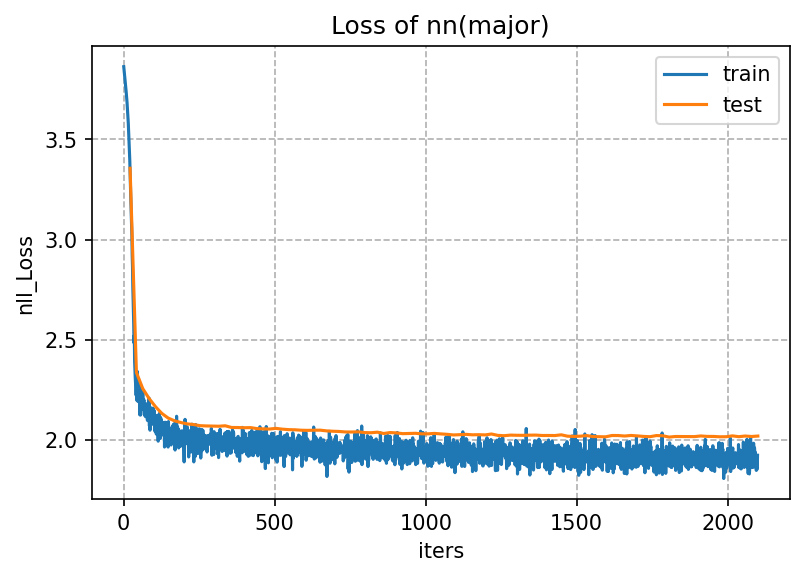

In [9]:
plt.figure(dpi=150)
plt.plot(train_loss,label='train')
plt.plot([i*21 for i in range(1,101)], test_loss[:], label='test')
plt.xlabel('iters')
plt.grid(linestyle='--')
plt.legend()
plt.ylabel('nll_Loss')
plt.title('Loss of nn(major)')
plt.show()

## 基本统计数据

#### 三和弦频数分布

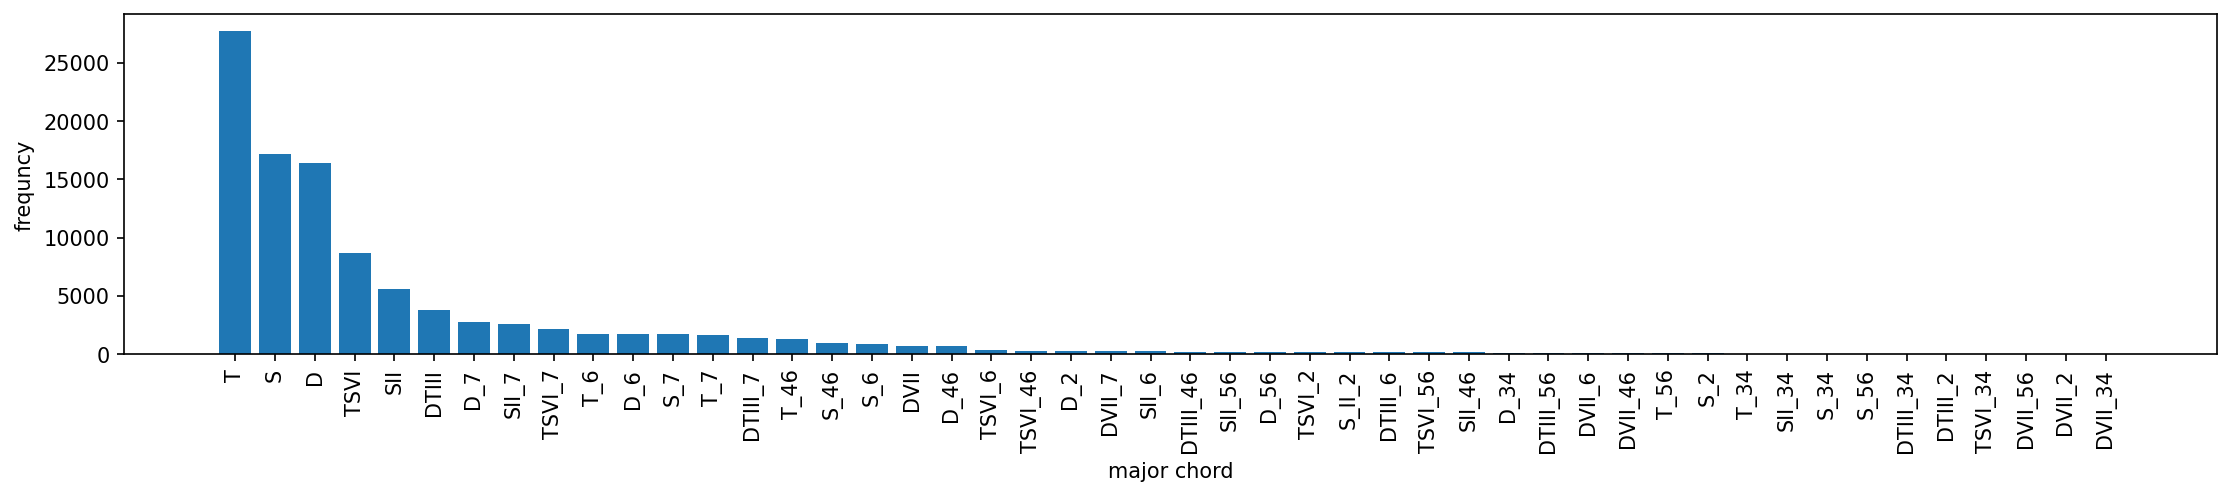

In [13]:
m = 'major'
num_dic = [(key, value) for key, value in triad_num_dic[m].items()]
num_dic = sorted(num_dic, key=lambda x:-x[1])
num = [i[1] for i in num_dic]
chord = [DL.chord_name_dic[i[0]] for i in num_dic]

plt.figure(figsize=(18,3),dpi=150)
plt.bar([i for i in range(len(num_dic))], num)
plt.xticks([i for i in range(len(num_dic))], chord, rotation=90)
#plt.grid(linestyle='--')
plt.ylabel('frequncy')
plt.xlabel('major chord')
plt.show()

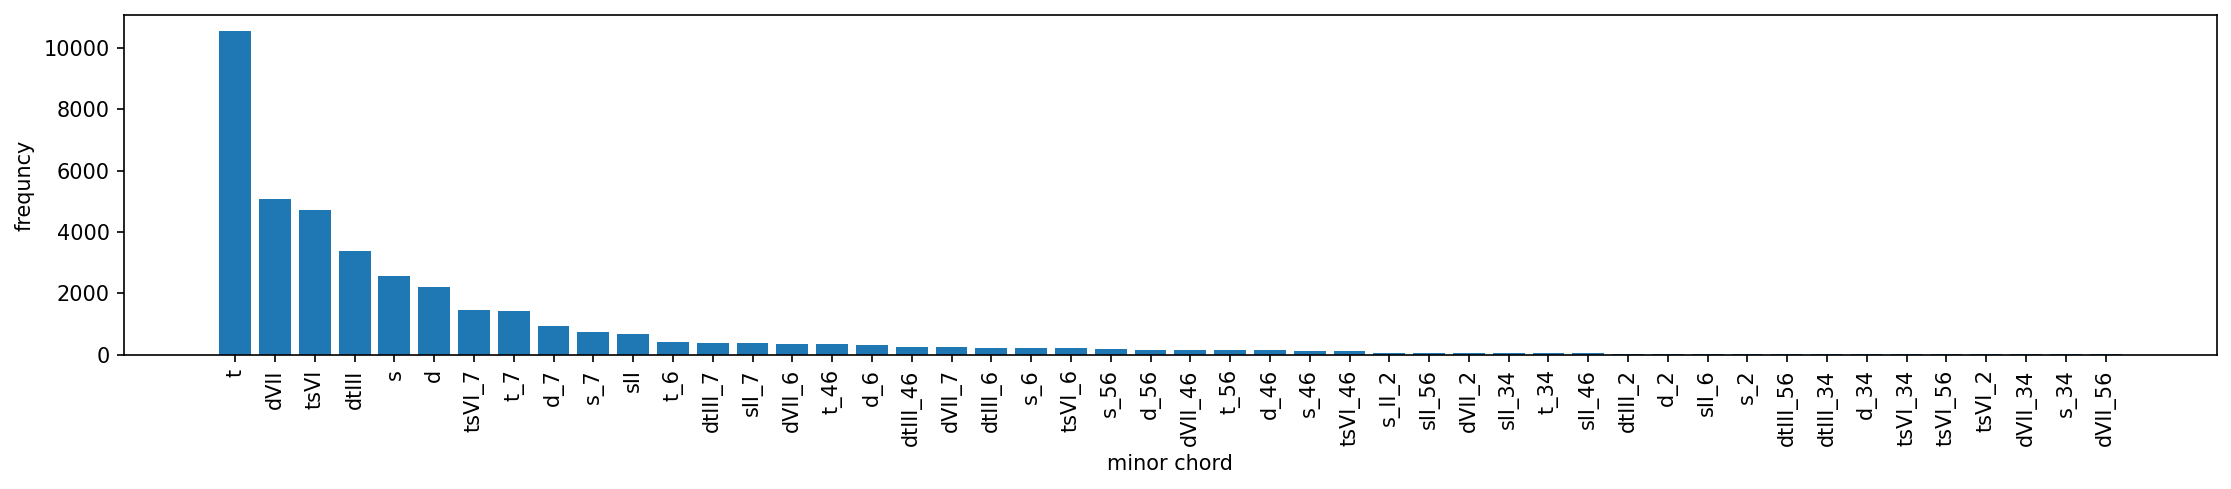

In [14]:
m = 'minor'
num_dic = [(key, value) for key, value in triad_num_dic[m].items()]
num_dic = sorted(num_dic, key=lambda x:-x[1])
num = [i[1] for i in num_dic]
chord = [DL.chord_name_dic[i[0]] for i in num_dic]

plt.figure(figsize=(18,3),dpi=150)
plt.bar([i for i in range(len(num_dic))], num)
plt.xticks([i for i in range(len(num_dic))], chord, rotation=90)
#plt.grid(linestyle='--')
plt.ylabel('frequncy')
plt.xlabel('minor chord')
plt.show()

## 测试

#### 均匀抽样的回溯算法

In [21]:
melody = np.array([0,7,2,0])
# CG.rule = rules
c = AC.generate(melody, method='lstm', tonic='minor')
print(c)

(0, 2, 5, 8) 0 (0, 3, 7) 7 hidden eight
(0, 2, 5, 8) 0 (3, 7, 0) 7 hidden eight
(0, 2, 5, 8) 0 (7, 0, 3) 7 hidden eight
(0, 2, 5, 8) 0 (3, 7, 10) 7 hidden eight
(0, 2, 5, 8) 0 (7, 10, 3) 7 hidden eight
(0, 2, 5, 8) 0 (10, 3, 7) 7 hidden eight
(0, 2, 5, 8) 0 (7, 10, 2) 7 hidden eight
(0, 2, 5, 8) 0 (10, 2, 7) 7 hidden eight
(0, 2, 5, 8) 0 (2, 7, 10) 7 hidden eight
(0, 2, 5, 8) 0 (0, 3, 7, 10) 7 hidden eight
(0, 2, 5, 8) 0 (7, 10, 0, 3) 7 p eight
(0, 2, 5, 8) 0 (7, 10, 2, 3) 7 p eight
(0, 2, 5, 8) 0 (10, 2, 3, 7) 7 hidden eight
(0, 2, 5, 8) 0 (2, 3, 7, 10) 7 hidden eight
(0, 2, 5, 8) 0 (7, 10, 2, 5) 7 p eight
(0, 2, 5, 8) 0 (10, 2, 5, 7) 7 hidden eight
(0, 2, 5, 8) 0 (2, 5, 7, 10) 7 hidden eight
(0, 2, 5, 8) 0 (8, 0, 3, 7) 7 hidden eight
(0, 2, 5, 8) 0 (0, 3, 7, 8) 7 hidden eight
(0, 2, 5, 8) 0 (7, 8, 0, 3) 7 p eight
(8, 0, 3, 5) 0 (0, 3, 7) 7 hidden eight
(8, 0, 3, 5) 0 (3, 7, 0) 7 hidden eight
(8, 0, 3, 5) 0 (7, 0, 3) 7 hidden eight
(8, 0, 3, 5) 0 (3, 7, 10) 7 hidden eight
(8, 0, 3, 5)

In [22]:
sys.path.append('../tools')
from mytools import *
for i in vec2chord(c):
    print(i)

(3, 7, 10, 0)
(2, 5, 7, 10)
(7, 10, 2)
(8, 0, 2, 5)
